<a href="https://colab.research.google.com/github/Priyanshu-Developer/Attendance/blob/master/Facial_Verification_with_a_Siamese_Network_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

In [3]:
import os 
print(len(os.listdir("data/negative")))

200


## 1.1 Install Dependencies

## 1.2 Import Dependencies

In [4]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from tkinter import Tk, Label
import numpy as np
from os.path import dirname,join

from PIL import Image, ImageTk

In [5]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [7]:
# Setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')
print(POS_PATH)

data/positive


# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [8]:
# http://vis-www.cs.umass.edu/lfw/

## 2.2 Collect Positive and Anchor Classes

# 2.x NEW - Data Augmentation

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(200)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(200)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(200)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data/anchor/5.jpg'


## 3.2 Preprocessing - Scale and Resize

In [12]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [13]:
img = preprocess('data/anchor/112.jpg')

In [14]:
img.numpy().max() 

1.0

## 3.3 Create Labelled Dataset

In [15]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
samples = data.as_numpy_iterator()


In [18]:
exampple = samples.next()

In [19]:
exampple

(b'data/anchor/7.jpg', b'data/positive/160.jpg', 1.0)

## 3.4 Build Train and Test Partition

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [21]:
res = preprocess_twin(*exampple)

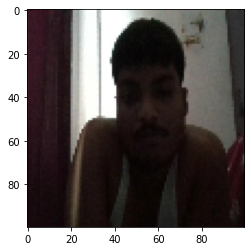

In [22]:
plt.imshow(res[1])

In [23]:
res[2]

1.0

In [24]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [25]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [27]:
inp = Input(shape=(100,100,3), name='input_image')

In [28]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [29]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [30]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [31]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [32]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [33]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [34]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [35]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [36]:
embedding = make_embedding()

In [37]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [38]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [39]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [40]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [41]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [42]:
siamese_layer = L1Dist()

In [43]:
distances = siamese_layer(inp_embedding, val_embedding)

In [44]:
classifier = Dense(1, activation='sigmoid')(distances)

In [45]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [46]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [47]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [48]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

## 5.1 Setup Loss and Optimizer

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
batch_1 = test_batch.next()

In [56]:
X = batch_1[:2]

In [57]:
y = batch_1[2]

In [58]:
y

array([1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [59]:
tf.losses.BinaryCrossentropy??

In [60]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

## 5.4 Build Training Loop

In [61]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [62]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [63]:
EPOCHS = 50

In [ ]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
 4/18 [=====>........................] - ETA: 9:05

# 6. Evaluate Model

## 6.1 Import Metrics

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [ ]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

In [ ]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

In [ ]:
y_true

## 6.3 Calculate Metrics

In [ ]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

In [ ]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

## 6.4 Viz Results

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [ ]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [ ]:
L1Dist

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [ ]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

In [ ]:
# View model summary
siamese_model.summary()

# 8. Real Time Test

## 8.1 Verification Function

In [ ]:
application_data\verification_images

In [ ]:
os.listdir(os.path.join('application_data', 'verification_images'))

In [ ]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

In [ ]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [ ]:
cap = cv2.VideoCapture(4)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results) > 0.9)

In [ ]:
results